In [3]:
#!pip install py2neo

import os
import pandas as pd
import matplotlib.pyplot as plt
import py2neo
from py2neo import Graph,Node,Relationship

import IPython

print ('py2neo version', py2neo.__version__)
%matplotlib inline

py2neo version 2021.2.3


In [4]:
# Connect the repository to the DB
db_url = 'neo4j@bolt://neo4j@localhost:7687'
db_pass = 'tweets'

graph = Graph(db_url, password = db_pass)

In [35]:
#consulta de prueba

nodos_tweet="MATCH (t:Tweet) RETURN t.id as id, t.text as tweet LIMIT 3"

#evaluamos las consultas
tweets=graph.run(nodos_tweet).to_data_frame() 

tweets

,id,tweet
0,1528014963599544321,@irenecardozopuy @brm59 Muy buen sábado Irene ...
1,1528014946927357958,@Nacional #70055
2,1528014932423233538,@SilGinocchio @EneEmeINFO @ObservadorUY Gracia...


# Conteo de nodos y relaciones

In [44]:
# conteo de nodos
nro_nodos_user="MATCH(u:User) RETURN Count(u)"
nro_nodos_tweet="MATCH(t:Tweet) RETURN Count(t)"
nro_nodos_hashtag="MATCH(h:Hashtag) RETURN Count(h)"

#evaluamos las consultas
result_users=graph.evaluate(nro_nodos_user)
result_tweets=graph.evaluate(nro_nodos_tweet)
result_hashtags=graph.evaluate(nro_nodos_hashtag)

#imprimo resultados
print(f'En la BD hay {result_users} nodos User, {result_tweets} nodos Tweet y {result_hashtags} nodos Hashtag.')


En la BD hay 55863 nodos User, 405389 nodos Tweet y 12884 nodos Hashtag.


In [46]:
# conteo de relaciones
consulta_1 = (
    "MATCH ()-[r]->() "
    "RETURN count(r);"
)

result_cons_1=graph.evaluate(consulta_1)

print(f'Hay {result_cons_1} relaciones')

consulta_2 = (
    "match ()-[r]->() "
    "with type(r) as rel_type, count(r) as number "
    "return rel_type, number;"
)

result_cons_2=graph.run(consulta_2).to_data_frame() 
result_cons_2

Hay 1098388 relaciones


,rel_type,number
0,TWEETED,405389
1,REPLY,185220
2,MENTIONS,427789
3,TAG,41782
4,QUOTE,38208


# Uso de geolocalización

In [47]:
# detalle de users y tweets de acuerdo al uso de geolocalización

consulta = (
    "match (u:User) -[:TWEETED]-> (t:Tweet {country: 'UY'}) "
    "return count(distinct(t)) as tweets_uy, count(distinct(u)) as users_uy;"
)

result_cons=graph.run(consulta).to_data_frame() 

print(f'Tweets posteados desde Uruguay con geolocalización activada: {result_cons.iloc[0,0]}')
print(f'Tweets sin geolocalización (referenciados por tweets con geolocalización): {result_tweets - result_cons.iloc[0,0]}')
print(f'Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: {result_cons.iloc[0,1]}')
print(f'Resto de los usuarios: {result_users - result_cons.iloc[0,1]}')


Tweets posteados desde Uruguay con geolocalización activada: 276546
Tweets sin geolocalización (referenciados por tweets con geolocalización): 128843
Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: 9309
Resto de los usuarios: 46554


# Hashtags más usados

In [54]:
# hashtags más usados

consulta = (
    "match (t:Tweet) -[r:TAG]-> (h:Hashtag) "
    "with h, count(r) as hashtag_count "
    "return h.tag as hashtag, hashtag_count "
    "order by hashtag_count desc "
    "limit 10;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,hashtag_count
0,uruguay,623
1,lamascarauy,553
2,marchadelsilencio2022,528
3,peñarol,411
4,mayomesdelamemoria,390
5,todossomosfamiliares,276
6,bts,238
7,nacional,234
8,puntopenalenel10,231
9,renunciaheber,228


# Tweets por hora del día

Text(0, 0.5, 'Número de tweets')

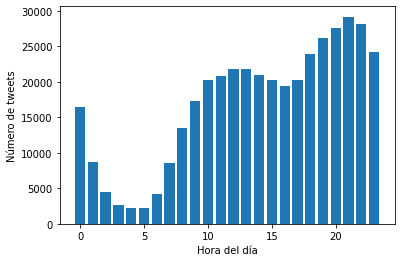

In [37]:
# tweet volume by hour of the day

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).hour as hour, count(t) as total_tweets "
    "return hour, total_tweets "
    "order by hour asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.hour, height=result_cons.total_tweets)
plt.xlabel('Hora del día')
plt.ylabel('Número de tweets')

Las horas en las que más se tweetea son las 20-22 hs, con pico a las 21 hs. A su vez, se observa también un aumento de frecuencia entre las 12 hs y las 13 hs, a la hora correspondiente al almuerzo en jornada laboral. 

# Flujo de Tweets en el mes de mayo

Text(0, 0.5, 'Número de tweets')

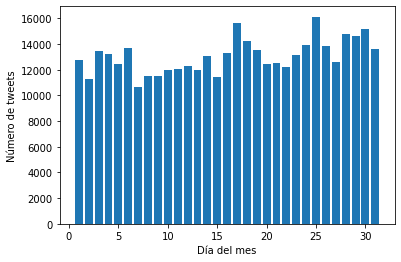

In [15]:
# tweet volume by day of the month

consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).day as day, count(t) as total_tweets "
    "return day, total_tweets "
    "order by day asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.day, height=result_cons.total_tweets)
plt.xlabel('Día del mes')
plt.ylabel('Número de tweets')

Se observan picos en el número de tweets los días 17 y 25 de mayo, y por otro lado en menor medida los días 28-30 de mayo. A continuación se analizan los hashtags más usados en estos días. 

In [51]:
# 17 de mayo

consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 17 "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 6"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,ciclonextratropical,103
1,peñarol,71
2,elclubgigante,66
3,uruguay,56
4,libertadores,51
5,vamoscarbonero,45


Jueves 17 de mayo: Jugó peñarol en la Libertadores y fue el día del ciclón subtropical.

In [52]:
# 25 de mayo

consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 25 "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 6"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,peñarol,83
1,libertadores,80
2,vamoscarbonero,53
3,elclubgigante,52
4,colón,42
5,122añosdelgpc,29


25 de mayo: Jugó peñarol en la Libertadores y se cumplieron 122 años del Gran Parque Central.

In [53]:
# 28-30 de mayo
consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day in [28,29,30] "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 15"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,monacogp,136
1,puntopenalenel10,111
2,uruguay,111
3,uclfinal,109
4,mytopfollowers,94
5,f1,86
6,teamverano,77
7,elpeorgobiernodelahistoria,77
8,peñarol,75
9,elclubgigante,68


28-30 de mayo: 29 Gran Premio de Mónaco (F1), 28 final UEFA Champions League, Ola de frío (30/5 - 1/6): "Este frío es insalubre no seas malo 🥶 #TeamVerano siempre"

# Detección de comunidades

In [39]:
# Se crea una proyección no dirigida del grafo y se guarda en el catálogo

projection = (
    "CALL gds.graph.project('tweets_no_hashtags', ['User', 'Tweet'], {relType: {type: '*', orientation: 'UNDIRECTED', properties: {} } }) "
)

# evaluamos las consultas
tweets_no_hashtags=graph.run(projection).to_data_frame() 

tweets_no_hashtags

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'relType': {'orientation': 'UNDIRECTED', 'agg...",tweets_no_hashtags,461252,2113212,2680


In [40]:
# Devolver los grafos del catálogo para ver si se guardo correctamente

query = (
    "CALL gds.graph.list() "
)

#evaluamos las consultas
tweets=graph.run(query).to_data_frame() 

tweets

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 35, 'min': 0, 'max': 6744, 'mean': 4.5...",tweets_no_hashtags,neo4j,20 MiB,21543389,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-26T10:42:32.570899000-03:00,2022-06-26T10:42:35.118773000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."


In [41]:
# Louvain community detection

consulta = (
  "CALL gds.louvain.stream('tweets_no_hashtags') "
  "YIELD nodeId, communityId "
  "WITH communityId, count(nodeId) as size, "
  "collect(nodeId) as ids "
  "MATCH (u:User)-->(t:Tweet)-[*1..2]->(n) "
  "WHERE id(u) in ids "
  "AND (n:Hashtag or n:User) " 
  "WITH communityId, size,  count(t) as count, n.tag as tag, n.name as name "
  "ORDER BY count(t) DESC "
  "RETURN communityId, size, collect(name)[0..15] AS users, collect(tag)[0..15] AS hashtags "
  "ORDER BY size DESC "
  "LIMIT 25"

)

result_cons=graph.run(consulta).to_data_frame() 
pd.set_option('max_colwidth', None)
display(result_cons)
pd.set_option('max_colwidth', 50)

,communityId,size,users,hashtags
0,288489,28958,"[PEÑAROL, Negro y de Peñarol ™, Nacional, Nati, PEÑAROL | Basketball, Punto Penal, Wilson Méndez, TONGA, CONMEBOL Libertadores, Cecilia Magdalena 🖐🏻, Jorge Savia, BUYSAN, me dicen Fidel, PUMA Uruguay, padreydecano.com]","[peñarol, vamoscarbonero, puntopenalenel10, libertadores, apertura2022, nacional, todosjuntos, lamascarauy, elequipoquenosune, marchadelsilencio2022, auf, gloriaeterna, elclubgigante, nuncamasterrorismodeestado, sudamericana]"
1,3806,27618,"[Nacional, 𝕴𝖓𝖘𝖔𝖕𝖔𝖗𝖙𝖆𝖇𝖑𝖊𝖒𝖊𝖓𝖙𝖊 𝕭𝖔𝖑𝖘𝖔, Tefaa1899🦋🇳🇱, laabdon.com.uy, 🇫🇷BOLSO AMARTE ES UN PLACER, PASIÓN TRICOLOR ((1010 Am)), Lea Garcia , Mauri Pérez, Valentín Canale 🎙🇳🇱, CONMEBOL Libertadores, Carmen rinaldi❤⚪💙, Dahi🇱🇺, Estudiantes de La Plata, Lucas, Club Atlético Unión]","[elclubgigante, nacional, orgullonacional, libertadores, decano1solo, jueganacional, laradiodelhincha, 123años, puntopenalenel10, mayotricolor, 123añosdeverdad, oídossanos, sudamericana, lafiestadelhincha, canterainagotable]"
2,199349,26179,"[Graciela Bianchi, leo sarro press, Luis Lacalle Pou, Frente Amplio, EL PAÍS, Sebas1, Rudhy Weiss, MonicaBatlle, Montevideo Portal, Romina Pesce, Telemundo, Yamandú Orsi, Sebastian Da Silva, Silvana Giachero, Alma]","[uruguay, mayomesdelamemoria, porquetodosesabe, marchadelsilencio2022, lamascarauy, santoyseña, 1demayo, memoria, setienequesaber, peñarol, hoy, malospensamientos, elpeorgobiernodelahistoria, laentrevista, hayordendenoaflojar]"
3,60369,23977,"[JACK_TORRANCE⬆️, ☪️🅰️®️🛴🌎💰, Radio Belcha®, India🇺🇾, Laura, Diego, AmableDonante, Daniel Bengoa, Mika, Stepha, medicenrubia, San🌻dra, Carol💫, edu, Nicolás Hidalgo]","[f1, monacogp, laradioestuya, marchadelsilencio2022, miamigp, f12022, mayomesdelamemoria, todossomosfamiliares, lamascarauy, nuevafotodeperfil, essereferrari, uruguay, tip, teaminvierno, gpmónaco]"
4,205575,16238,"[Isabel_, gaby 💖💙❤️, Lunaro🎶🎼, Vicky, Jazmín 💙🇺🇾, Silvia, Genny Rodríguez, Dr. Guillermo de los Santos, Jacquelin Sánchez Quintero, Gladys Nohemi, Toñi Valiente. ® ™, Luis Pagani, Joyce 🐶🐶🐶🐱, Pablo ⛩️, Sonia Maldonado]","[mytopfollowers, grupodeamigosentwitter, tiktok, lunagitana, nuevafotodeperfil, hayordendenoaflojar, teamverano, lavidaesbella, seanfelices, sefeliz, uruguay, buenlunes, lamascarauy, teaminvierno, puntopenalenel10]"
5,1199,13465,"[Luis Lacalle Pou, MSP - Uruguay, Daniel Salinas, Luis Alberto Heber, Partido Nacional, Ministerio de Desarrollo Social, Jose Luis Satdjian, Sebastian Da Silva, Alfin, Lorena Ponce de León, Pablo Mieres, Frente Amplio, Martin Lema, Adry More😜, Beatriz Argimón]","[hayordendenoaflojar, haciauncompromisonacional, uruguay, ahora, mayomesdelamemoria, marchadelsilencio2022, elclubgigante, elpeorgobiernodelahistoria, patiodeloslamas, niunapersonaporperdida, lamascarauy, casadeloslamas, renunciaheber, puntopenalenel10, unasolasalud]"
6,195559,11463,"[💫💫Estela❤️😷😷🏆🖤💛, Alejandro Raffo, Majo, Graciela Gadea, Ricardo Pons, Nestor Grajales, Julio Cesar Pradie Colmán, Flora Cukierman, jose ernesto costemalle, MaRosa, CIUDADANOJorgeCASTRO, Nora 🦋💐🌸, Luis Lacalle Pou, Maria, Mi Nona Celia]","[pintouruguay, felizviernes, felizjueves, eltuitazo2, felizmiercoles, nuevafotodeperfil, mytopfollowers, felizsabadoatodos, felizmartesatodos, uruguay, felizviernesatodos, teamverano, felizsabado, redwilsonista, juventudredwilsonista]"
7,62548,10359,"[ANALI BENTENCOURT, Beatriz García Montejo, Susy, Michele Piquet, DECOS HIPPOCRATES, Roberto, Bea, Patricia, Juana Lalo, Luz Rodríguez 🇺🇾🇺🇾🇺🇾🌱🌼 #CadenaDeZurdos, angel camarano, nefridio☀️🌊✌🌱🕊❤, Colo, mónica, ᒪOᒪO🦀(Lapaztodojunto)]","[marchadelsilencio2022, mayomesdelamemoria, todossomosfamiliares, elpeorgobiernodelahistoria, mytopfollowers, renunciaheber, blancospillos, nuevafotodeperfil, buenlunes, montevideo, nadielee, buenmartes, memoriaverdadyjusticia, teamverano, 1demayo]"
8,186900,10070,"[Club Atlético Aguada, PEÑAROL | Basketball, FUBB, Pablo Batista, ✨Val✨, PablO RiverA ©, Pablo , Daniel , Liga Uruguaya de Básquetbol (Ofici

In [ ]:
# Prueba con proyección sólo con nodos User

user_projecion = 'MATCH (u:User) return id(u) as id'
relationships_projection = (
    "MATCH (u1:User)-[:TWEETED]->(t1:Tweet)<-[:QUOTE|REPLY]-(t2:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
    "UNION "
    "MATCH (u1:User)<-[:MENTIONS]-(t1:Tweet)<-[:QUOTE|REPLY]-(t2:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
    "UNION "
    "MATCH (u1:USER)<-[:MENTIONS]-(t1:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
)

projection = (
    f"CALL gds.graph.project.cypher('users', '{user_projecion}', '{relationships_projection}') "
)

#evaluamos las consultas
users=graph.run(projection).to_data_frame() 

users

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,projectMillis
0,MATCH (u:User) return id(u) as id,MATCH (u1:User)-[:TWEETED]->(t1:Tweet)<-[:QUOT...,users,55863,187890,13495


In [22]:
# Louvain community detection: with users projection.

consulta = (
  "CALL gds.louvain.stream('users') "
  "YIELD nodeId, communityId "
  "WITH communityId, count(nodeId) as size, "
  "collect(nodeId) as ids "
  "MATCH (u:User)-->(t:Tweet)-[*1..2]->(n) "
  "WHERE id(u) in ids "
  "AND (n:Hashtag or n:User) " 
  "WITH communityId, size,  count(t) as count, n.tag as tag, n.name as name "
  "ORDER BY count(t) DESC "
  "RETURN communityId, size, collect(name)[0..15] AS users, collect(tag)[0..15] AS hashtags "
  "ORDER BY size DESC "
  "LIMIT 25"

)

result_cons=graph.run(consulta).to_data_frame() 
pd.set_option('max_colwidth', None)
display(result_cons)
pd.set_option('max_colwidth', 50)

,communityId,size,users,hashtags
0,237,2837,"[Isabel_, 💫💫Estela❤️😷😷🏆🖤💛, Luis Lacalle Pou, Alejandro Raffo, Majo, Ricardo Pons, Graciela Gadea, Nestor Grajales, Julio Cesar Pradie Colmán, CIUDADANOJorgeCASTRO, Flora Cukierman, jose ernesto costemalle, Nora 🦋💐🌸, Maria, MaRosa]","[uruguay, payaso, mytopfollowers, hayordendenoaflojar, pintouruguay, eltuitazo2, nuevafotodeperfil, felizjueves, felizviernes, teamverano, puntadeleste, lamascarauy, elpeorgobiernodelahistoria, felizmiercoles, mayomesdelamemoria]"
1,9175,2550,"[PEÑAROL, PEÑAROL | Basketball, Negro y de Peñarol ™, Nati, Nacional, 👑🌻𝓐𝓷𝓽𝓸𝓷𝓮𝓵𝓵𝓪💎👑, Wilson Méndez, Cecilia Magdalena 🖐🏻, BUYSAN, TONGA, CONMEBOL Libertadores, PUMA Uruguay, Jorge Savia, PEÑAROL | Rugby, FUBB]","[peñarol, vamoscarbonero, libertadores, copaofi, siempreatulado, lub, apertura2022, vamoslavalleja, uruguaylateaurinegro, puntopenalenel10, nacional, elequipoquenosune, todosjuntos, lamascarauy, ahora]"
2,19857,2468,"[Nacional, 𝕴𝖓𝖘𝖔𝖕𝖔𝖗𝖙𝖆𝖇𝖑𝖊𝖒𝖊𝖓𝖙𝖊 𝕭𝖔𝖑𝖘𝖔, 𝚂iL ❤️‍🔥 #36303, Punto Penal, laabdon.com.uy, Tefaa1899🦋🇳🇱, PASIÓN TRICOLOR ((1010 Am)), 🇫🇷BOLSO AMARTE ES UN PLACER, Valentín Canale 🎙🇳🇱, Mauri Pérez, Lea Garcia , CONMEBOL Libertadores, PEÑAROL, Estudiantes de La Plata, Carmen rinaldi❤⚪💙]","[elclubgigante, puntopenalenel10, nacional, orgullonacional, libertadores, decano1solo, jueganacional, 123años, laradiodelhincha, mayotricolor, 123añosdeverdad, lamascarauy, oídossanos, decanoesnacional, sudamericana]"
3,12655,2177,"[Luis Lacalle Pou, Frente Amplio, Telemundo, Graciela Bianchi, EL PAÍS, Montevideo Portal, Thalos 🇷🇺, Bauti Gil Castillo, la diaria, Luis Alberto Heber, Martín Irigoyen 🇺🇾 🌱🖤💙, Sebas1, leo sarro press, Subrayado, Bettiana Díaz Rey]","[elpopularuy, uruguay, marchadelsilencio2022, mayomesdelamemoria, ahora, renunciaheber, elpeorgobiernodelahistoria, maldonado, todossomosfamiliares, montevideo, lamascarauy, mirádiferente, peñarol, polémicaenel10, ladiariajusticia]"
4,12493,2036,"[JACK_TORRANCE⬆️, ☪️🅰️®️🛴🌎💰, Beatriz García Montejo, Michele Piquet, 🌼 Juan Pa. 🖤💛🖤💛💜, Bea, DECOS HIPPOCRATES, ᒪOᒪO🦀(Lapaztodojunto), ANALI BENTENCOURT, Susy, LMP, Roberto, mónica, Colo, Juana Lalo]","[marchadelsilencio2022, mayomesdelamemoria, todossomosfamiliares, elpeorgobiernodelahistoria, renunciaheber, lamascarauy, inseguridad, uruguay, presente, blancospillos, dondeestan, mvdnoticias, nuevafotodeperfil, memoriaverdadyjusticia, montevideo]"
5,26336,635,"[Daniel Salinas, MSP - Uruguay, Luis Lacalle Pou, Jose Luis Satdjian, Ministerio de Desarrollo Social, EL PAÍS, Martin Lema, Comunicación Presidencial, ASSE Comunica, Matias Pereyra, Graciela Bianchi, Montevideo Portal, Miguel Ángel Chagas., Sergio Blanco, Frente Amplio]","[hayordendenoaflojar, uruguay, metgala, ahora, lamascarauy, mayomesdelamemoria, planinvierno, covidー19, niunapersonaporperdida, everest, eutanasiasi, marchadelsilencio2022, noalaagenda2030, elegiresdignidad, elpeorgobiernodelahistoria]"
6,1368,487,"[MaGnUs, Min. Diego González González, 小武, AboutAGeekGirl ︽✵︽ 💚🏳️‍🌈, TVCIUDAD, Lisandro Nieva, Desaparecidos.org.uy, Pablo Mieres, Luis Lacalle Pou, Carlitos D. Eslovenia 💖💜💙, Perdidos En El Éter, MVD Noticias, Valentina Dorrego, RaⓂi, Jennifer Dominguez]","[mvdnoticias, marchadelsilencio2022, mayomesdelamemoria, tvciudad, startrek, todossomosfamiliares, laaldea, culturadebarrio, nbaxtvciudad, startrekdiscovery, rpg, espaciosocialtabarevasquez, nuncamás, presente, maratonmontevideo]"
7,3154,352,"[Club Atlético Aguada, Radio Belcha®, Daniel Bengoa, ✨Val✨, Pablo Batista, PablO RiverA ©, Pablo , PEÑAROL | Basketball, Nicolás Hidalgo, FUBB, Liga Uruguaya de Básquetbol (Oficial), Al Thornton, Mario, Hinchada Aguatera, Gustavo Cabrera]","[aguada100años, aguada, lub, arribamuchachada, lamascarauy, playoffs, peñarol, mayomesdelamemoria, vamoslaspibas, encuestabuscadores, masterchefuy, somosaguada, vamoscarbonero, d11os, marchadelsilencio2022]"
8,4325,296,"[𝗧𝗲𝗹𝗲𝗱𝗼𝗰𝗲 📺, Quién Es La Máscara Uruguay, Liga Bichera Montevideo Refugio, EL PAÍS, MaxidelaCruz, Eugenia

In [38]:
# Drop graph projection from catalog
drop = (
    "CALL gds.graph.drop('tweets_no_hashtags')"
)

result_drop = graph.run(drop).to_data_frame()
result_drop

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,tweets_no_hashtags,neo4j,,-1,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-18T18:02:46.443673000-03:00,2022-06-18T18:02:47.002939000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."


# Proporción de tweets urguayos capturados por nuestra base

Para estimar la proporción de tweets uruguayos que contiene nuestra base de datos se usan 3 hashtags de Uruguay.

In [57]:
consulta = (
    "match (t:Tweet) -[:TAG]-> (h:Hashtag) "
    "where h.tag in ['lamascarauy', 'marchadelsilencio2022', 'renunciaheber'] "
    "with h.tag as hashtag, count(t) as db_hashtag_count "
    "return hashtag, db_hashtag_count;"
)

result_cons=graph.run(consulta).to_data_frame() 

# from twarc2 query
result_cons['total_hashtag_count'] = [25866, 9044, 16966]
result_cons['db_proportion'] = result_cons['db_hashtag_count'] / result_cons['total_hashtag_count']
result_cons

,hashtag,db_hashtag_count,total_hashtag_count,db_proportion
0,marchadelsilencio2022,528,25866,0.020413
1,renunciaheber,228,9044,0.025210
2,lamascarauy,553,16966,0.032595


Los tres hashtags evaluados están entre los más usados del mes, y a su vez son específicos de Uruguay (es improbable que sean utilizados en otros países). Se ve que la proporción de tweets recogidos por nuestra base de datos sobre el total está entre el 2% y el 3%.

# Otras consultas

In [42]:
# Lacalle Pou Tweets

consulta = (
    "match (lacalle:User {username:'LuisLacallePou'}) -[:TWEETED]-> (t:Tweet)"
    "return count(t) as db_lacalle_tweets"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,db_lacalle_tweets
0,26


In [12]:
# tweet volume by department

consulta = (
    "match (t:Tweet {country: 'UY'}) "
    "with t.department as department, count(t) as total_tweets "
    "where total_tweets > 1000 "
    "return department, total_tweets "
    "order by total_tweets desc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,department,total_tweets
0,Montevideo,169267
1,Canelones,29638
2,Maldonado,22716
3,Colonia,9406
4,Salto,5323
5,San José,4704
6,Soriano,4109
7,Paysandú,3739
8,Florida,3314
9,Cerro Largo,3237


In [13]:
#3 hashtags, country:'UY

consulta_1 = (
    "match (t:Tweet {country:'UY'}) -[:TAG]-> (h:Hashtag) "
    "where h.tag in ['lamascarauy', 'marchadelsilencio2022', 'renunciaheber'] "
    "with h.tag as tag, count(t) as db_hashtag_count_uy "
    "return tag, db_hashtag_count_uy;"
)

result_cons_1=graph.run(consulta_1).to_data_frame() 
display(result_cons_1)

,tag,db_hashtag_count_uy
0,marchadelsilencio2022,397
1,renunciaheber,174
2,lamascarauy,387


In [ ]:
#consulta de prueba

nodos_tweet="MATCH (u: User) -[:TWEETED]-> (t:Tweet) RETURN u.name as user, t.text as tweet, t.like_count as like_count ORDER BY t.like_count DESC LIMIT 3"

#evaluamos las consultas
tweets=graph.run(nodos_tweet).to_data_frame() 

tweets

,user,tweet,like_count
0,Elon Musk,I hope that even my worst critics remain on Tw...,3322952
1,방탄소년단,#StopAsianHate\n#StopAAPIHate https://t.co/mOm...,2550038
2,방탄소년단,아직 날씨가 쌀쌀하니 따뜻하게 입고 다니세요 !\n#JIMIN https://t.c...,2306319


In [ ]:
# usuarios con más seguidores

consulta = (
    "match (u:User) -[r:TWEETED]-> (t:Tweet) "
    "with u, count(t) as tweets_in_uy_conversation, u.name as name, u.followers as followers "
    "return name, followers, tweets_in_uy_conversation "
    "order by followers desc "
    "limit 10;"
)

result_cons = graph.run(consulta).to_data_frame() 
result_cons

,name,followers,tweets_in_uy_conversation
0,Elon Musk,96333321,22
1,Lady Gaga,84737729,4
2,Ellen DeGeneres,77527323,4
3,Kim Kardashian,72589607,1
4,Bill Gates,59326794,1
5,CNN,58389658,2
6,NASA,57796162,1
7,The New York Times,53157945,3
8,LeBron James,51460079,3
9,방탄소년단,46161306,6
